In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = list(left.select_traces())
    t2 = list(right.select_traces())
    _clear_props([*t1, *t2])
    fig.add_traces(t1, rows=1, cols=1)
    fig.add_traces(t2, rows=1, cols=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [6]:
runners = pd.read_csv('data/cherryBlossomMen.csv')
runners_over_17 = runners[runners["age"] > 17]
runners_over_17 = runners_over_17[runners_over_17["age"] < 76]

dogs = pd.read_csv('data/akc.csv').dropna()
sfh_all = pd.read_csv('data/sfhousing.csv', on_bad_lines='skip')

# DAWN
colspecs = [(0,6), (14,29), (33,35), (35, 37), (37, 39), (1213, 1214)]
varNames = ["id", "wt", "age", "sex", "race","type"]
dawn = pd.read_fwf('data/DAWN-Data.txt', colspecs=colspecs, header=None, index_col=0,
                   names = varNames)

(sec:viz_data_design)=
# Incorporating the Data Design


When we create a visualization, it's important to consider the data scope, especially the data design
(see {numref}`Chapter %s <ch:data_scope>`).
Considering the question of how the data were collected can impact our plot choice and the comparisons we portray.
These considerations include the time and place that the data were collected and the design used to select a sample.
We look at a few examples of how the data scope can inform the visualizations we make.

## Data Collected over Time 

When data are collected over time, we typically make a line plot that puts timestamps on the x-axis and a feature of interest on the y-axis to look for trends in time.
As an example, let's revisit the data on San Francisco housing prices. 
These data were collected from 2003 through 2008 and show the crash in 2008/2009 of the [US housing bubble](https://en.wikipedia.org/wiki/2000s_United_States_housing_bubble).
Since time is a key aspect of the scope of these data, let's visualize sale price as a time series. Our earlier explorations showed that sale price
is highly skewed so let's work with percentiles, rather than averages. We plot the median price (this is a form of smoothing as we saw earlier in this chapter):

In [4]:
def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], infer_datetime_format=True)
    return sfh.assign(date=dates).set_index('date')

percs = [10, 30, 50, 70, 90]

def find_percentiles(series):
    prices = np.percentile(series, percs, method='lower')
    return pd.Series(prices, index=percs)

monthly_percentiles = (sfh_all
 .pipe(parse_dates)
 .resample('M')
 ['price']
 .apply(find_percentiles)
 .reset_index()
 .rename(columns={'level_1': 'percentile'})
)

rel_prices = (monthly_percentiles
 .groupby('percentile')
 ['price']
 .transform(lambda s: s / s.iloc[0])
)

rel_percentiles = monthly_percentiles.assign(rel_price=rel_prices)

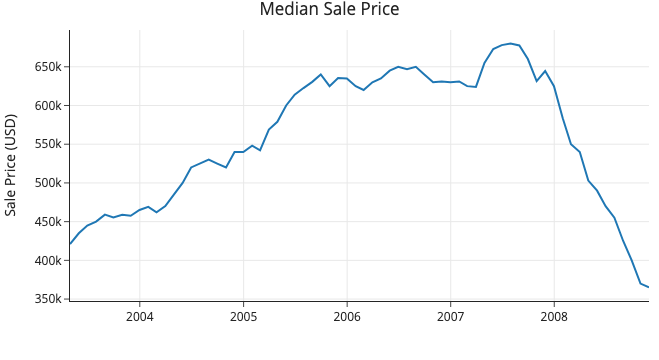

In [5]:
sfh_labels={'price':"Sale Price (USD)", 'date':""}
medians = rel_percentiles.query('percentile == 50')
fig = px.line(medians, x='date', y='price',
              title='Median Sale Price',
              labels=sfh_labels,
              width=500, height=250)
margin(fig, t=30)

This plot shows the rise in prices from 2003 to 2007 and the fall in 2008.
But we can show more information by plotting a few additional percentiles instead of just the median. Let's draw separate lines for the 10th, 30th, 50th (median), 70th, and 90th percentile sale prices. When we examine prices over time, we typically need to adjust for inflation so that the comparisons are on the same footing. In addition to adjusting for inflation, let's plot the prices 
relative to the starting price in 2003 for each of the percentiles.
This means that all the lines start at y=1 in 2003.
(A value of 1.5 for the 90th percentile in 2006 indicates that the sale price is 1.5 times the 90th percentile in 2003.)
This normalization lets us see how the housing crash affected home owners in the different parts of the market.

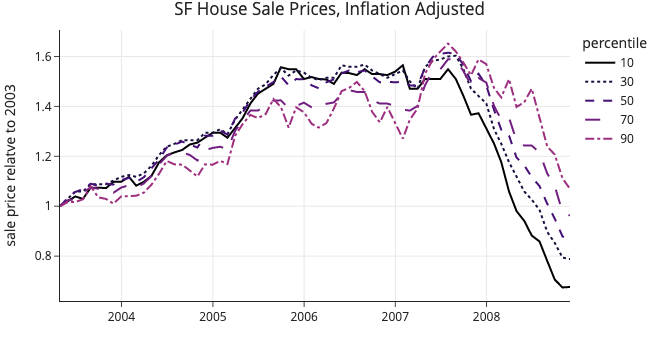

In [18]:
infl_2003 = [1, 2.66, 6.14, 9.57, 12.69,17.01, 16.60]

fig = px.line(rel_percentiles, x='date', y='rel_price', 
              line_dash='percentile', color='percentile',
              color_discrete_sequence=plotly.express.colors.sequential.Magma,
              title='SF House Sale Prices, Inflation Adjusted',
              labels=dict(date='',rel_price='sale price relatve to 2003'),
              width=600, height=350)
margin(fig, t=30)

When we follow the 10th percentile line plot over time, we see that it
increases quickly in 2005, stays high relative to its 2003 value for a few
years, and then drops earlier and faster than the other percentiles. This tells us that the less expensive houses, such as starter homes, suffered greater volatility and lost much more value in the housing market crash.
In contrast, higher-end homes were affected less by the crash; at the end of 2008, the 90th percentile home prices were still higher than 2003 prices.
Applying this bit of domain knowledge helps reveal trends in the data that we might otherwise miss, and shows how we can use the data design to improve a visualization.

The housing data are an example of observational data that form a complete census in a geographic region over a specific period of time. Next we consider another observational study where self-selection and the time period impact the visualization.  

## Observational Studies

We need to be particularly cautious with data that do not form a census or scientific sample.
We should also take care with cross-sectional studies, whether from a census or scientific sample. For this example, we revisit the data from the Cherry Blossom Ten-Mile Run.
Earlier in this chapter, we made a smoothed curve to examine the relationship between race time and age.
We reproduce this plot:

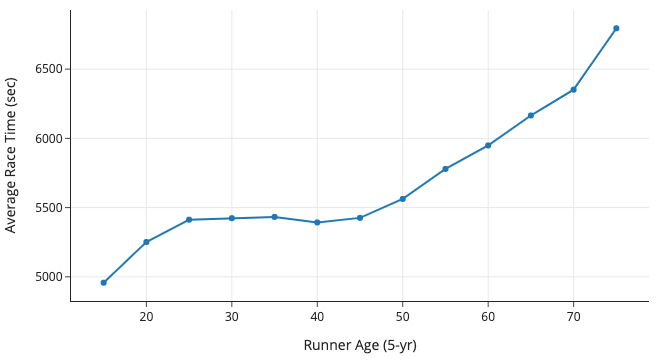

In [10]:
times = (
    runners_over_17.assign(age_5yr=runners_over_17['age'] // 5 * 5)
    .groupby('age_5yr')['time'].mean().reset_index()
)

px.line(times, x='age_5yr', y='time',
        labels={'time':"Average Race Time (sec)", 'age_5yr':"Runner Age (5-yr)"},
        markers=True, 
        width=350, height=250)

It's tempting to look at this plot and conclude something like: a runner at age 60 can expect to typically take an additional 600 seconds to finish the run than when they were 40. 
However, this is a *cross-sectional* study, not a *longitudinal* study. The study does not follow people over time, instead it gets a snapshot of a cross-section of people.
The 60-year-old runners represented in the plot are different people than the 40-year-old runners.
These two groups could be different in ways that affect the relationship between race time and age. 
As a group, the 60-year-olds in the race are likely to be more fit for their age than the 40-year-olds.
In other words, the data design doesn't let us make conclusions about individual runners.
The visualization isn't wrong, but we need to be careful about the conclusions we draw from it.

The design is even more complex because we have race results from many years.
Each year forms a cohort, a group of racers, and from one year to the next, the cohort changes.
We create a visualization that makes this message clear by comparing runners in different race years. 
Below, we've separately plotted lines for the runners in 1999, 2005, and 2010:

In [8]:
few = (runners_over_17.assign(age5=runners_over_17['age'] // 5 * 5)
       .query('year in [1999, 2005, 2010]')
       .groupby(['year', 'age5'])
       ['time']
       .median()
       .reset_index()
      )

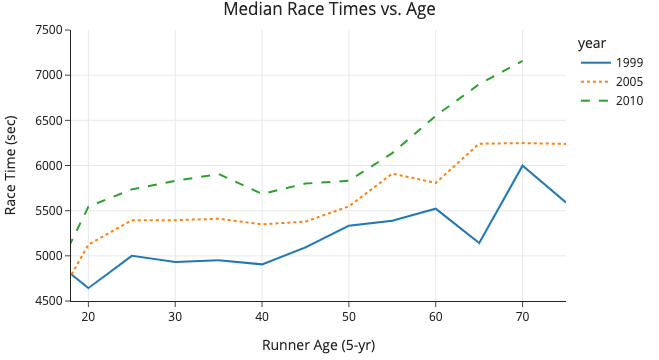

In [9]:
fig = px.line(few, x='age5', y='time', color='year',
              line_dash='year',
              title='Median Race Times vs. Age',
              width=450, height=250,
             )
fig.update_xaxes(range=[18, 75], title="Runner Age (5-yr)")
fig.update_yaxes(range=[4500, 7500], title="Race Time (sec)")
margin(fig, t=30)

We see that the median race times in 2010 are higher at every age group than the times for 
the runners in 2005, and in turn, the 2005 runners times are higher than for the runners in 1999.
It's interesting that race times have slowed over the years. 
This is quite likely due to the increased popularity of the race where there is higher participation from novice runners in more recent years. This example has shown how we need to be aware of the data scope when interpreting patterns. We also need to keep data scope in mind with scientific studies. This is the topic of the next section.

## Unequal Sampling

In a scientific study, we must consider the sample design because it can impact our plots. Some samples draw individuals at unequal rates and this needs to be accounted for in our visualizations.
We have seen an example of a scientific study in {numref}`Chapters %s <ch:files>` and {numref}` %s <ch:wrangling>`: the Drug Abuse Warning Network (DAWN) survey.  These data are from a complex randomized study of drug-related emergency room visits, and each record comes with its weight that we must use in order to accurately represent the emergency room visits in the population. The two bar plots below show the distribution of the type of ER visit. The one on the left doesn't use the survey weights and the one on the right does.

In [9]:
dawn_type = dawn.groupby('type')['wt'].sum()
dawn_wt_norm = dawn_type/sum(dawn_type)
dawn_wts = dawn_wt_norm.sort_values(ascending=False)

dawn_cts = dawn['type'].value_counts(normalize=True)

types = {1:'suicide attempt', 2:'detox', 3:'alcohol', 4:'adverse reaction',
        5:'overmedication', 6:'malicious poisoning', 7:'accidental ingestion', 
         8:'other'}

types_ct = {k: types[k] for k in dawn_cts.index}
types_wt = {k: types[k] for k in dawn_wts.index}

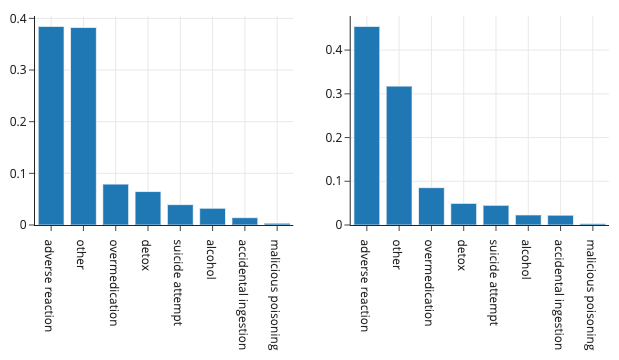

In [135]:
fig1 = px.bar(x=types_ct, y=dawn_cts.values)
fig2 = px.bar(x=types_wt, y=dawn_wt_sort.values)

fig = left_right(fig1, fig2)
fig.show()

In the unweighted bar plot, the "Other" category is as frequent as the "Adverse Reaction" category. However, when weighted, "Other" drops to about 2/3 of "Adverse Reaction". Ignoring sampling weights can give a misleading presentation of a distribution. Whether for a histogram, bar plot, box plot, two-dimensional contour, or smooth curve we need to use the weights to get a representative plot. Another aspect of the data scope that can impact our choice of plots is where the data are collected, which is the topic of the next section.

## Geographic Data

When our data contains geographic information like latitude and longitude, we should consider making a map, in addition to the typical plots.
For example, the map below shows the locations for US Air Quality sensors,
which are the focus of the case study in {numref}`Chapter %s <ch:pa>`.

In [10]:
def rollup_dup_sites(df):
    return (
        df.groupby('AQS_Site_ID')
        .first()
        .reset_index()
    )

def subset_aqs(df):
    subset = df[['AQS_Site_ID', 'Latitude', 'Longitude']]
    subset.columns = ['site_id', 'lat', 'lon']
    return subset

aqs_sites = (pd.read_csv('data/list_of_aqs_sites.csv')
             .pipe(rollup_dup_sites)
             .pipe(subset_aqs))

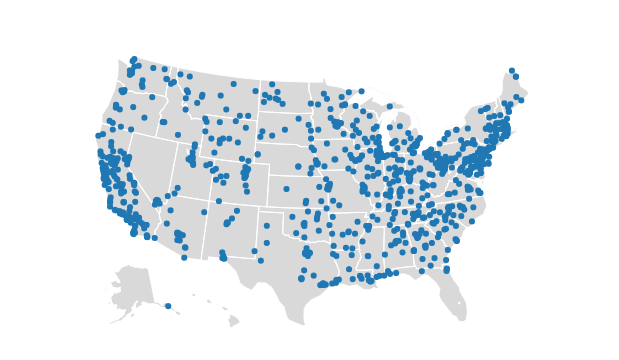

In [11]:
fig = px.scatter_geo(aqs_sites, lat='lat', lon='lon',
               locationmode='USA-states', scope='usa',
               width=550, height=300)

fig.update_layout(geo = dict(landcolor = 'rgb(217, 217, 217)'))
fig.show()

Notice that there are many more points in California and the Eastern Seaboard.
A simple histogram of air quality with data from all of these sensors would misrepresent the distribution of air quality in the US. To incorporate the spatial aspect into the distribution, we can add air quality measurements to the map with different color markers, and we can facet the histograms of air quality by location.

In addition to plotting features like bars, color, and line styles, we also have the option to add text with contextual information to make our plot more informative. This is the topic of the next section.